In [ ]:
## Needed
### IOU for bounding boxex 
### LR decrease after 30 epoch

In [1]:
import os
import shutil
import numpy as np
import cv2
from glob import glob
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
seed = 42
g = torch.Generator().manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
image_shape = (3,300,300)
batch_size = 32
lr = 1e-3
epochs = 50
val_size = 0.1

## Data

### Downloading

In [4]:
import tarfile

!wget -q -O /kaggle/working/caltech-101.zip "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1"
!unzip -q /kaggle/working/caltech-101.zip

with tarfile.open('/kaggle/working/caltech-101/101_ObjectCategories.tar.gz', 'r:gz') as tar_ref:
    tar_ref.extractall('/kaggle/working/')

with tarfile.open('/kaggle/working/caltech-101/Annotations.tar', 'r') as tar_ref:
    tar_ref.extractall('/kaggle/working/')

### Cleaning

In [5]:
objectCategories_path = '/kaggle/working/101_ObjectCategories/'
annotations_path = '/kaggle/working/Annotations/'

In [6]:
img_folders = glob('*', root_dir=objectCategories_path)
annot_folders = glob('*', root_dir=annotations_path)

## folders in Annotations but not having same name at 101_ObjectCategories (annot - img)
annot_img = [os.path.join(annotations_path, f) for f in annot_folders if f not in img_folders]
## folders in 101_ObjectCategories but not having same name at Annotations (img - annot)
img_annot = [os.path.join(objectCategories_path, f) for f in img_folders if f not in annot_folders]

## Delete Non-existed folders or files
for f in img_annot:
    if os.path.exists(f):
        if os.path.isdir(f):
            shutil.rmtree(f)
        else:
            os.remove(f)

for f in annot_img:
    if os.path.exists(f):
        if os.path.isdir(f):
            shutil.rmtree(f)
        else:
            os.remove(f)

## This image has ba boundingbox
bad_img = objectCategories_path + 'wrench/image_0010.jpg'
bad_annot = annotations_path + 'wrench/annotation_0010.mat'
if os.path.exists(bad_img): os.remove(bad_img)
if os.path.exists(bad_annot): os.remove(bad_annot)

### list comprehension with one line if-else
# [shutil.rmtree(f) if os.path.isdir(f) else os.remove(f) for f in img_annot if os.path.exists(f)]
# [shutil.rmtree(f) if os.path.isdir(f) else os.remove(f) for f in annot_img if os.path.exists(f)]

### Data integrity check
checks that each image path corresponding to its annotation path

In [7]:
img_paths = sorted(glob(objectCategories_path + '*/*.jpg'))
annot_paths = sorted(glob(annotations_path + '*/*.mat'))

for idx,(x,y) in enumerate(zip(img_paths, annot_paths)):
    x_split, y_split = x.split('/'), y.split('/')
    if x_split[-2] != y_split[-2] or y_split[-1].split('_')[1].split('.')[0] != x_split[-1].split('_')[1].split('.')[0]:
        print(f'bad matching between: {x} and {y}')


### Spliting

In [8]:
img_folders_cleand = sorted(glob('*', root_dir=objectCategories_path))
cls_to_idx = {i:j for j,i in enumerate(img_folders_cleand)}
idx_to_cls = {i:j for j,i in cls_to_idx.items()}

img_paths = sorted(glob(objectCategories_path + '*/*.jpg'))
annot_paths = sorted(glob(annotations_path + '*/*.mat'))

train_img_paths, temp_img_paths, train_annot_paths, temp_annot_paths = train_test_split(img_paths, annot_paths, test_size=val_size*2, random_state=seed, shuffle=True)
test_img_paths, val_img_paths, test_annot_paths, val_annot_paths = train_test_split(temp_img_paths, temp_annot_paths, test_size=0.5, random_state=seed, shuffle=True)


print(f"All images: {len(img_paths)} \t All annotations: {len(annot_paths)}")
print(f"Training images: {len(train_img_paths)} \t Training annotations: {len(train_annot_paths)}")
print(f"Validation images: {len(val_img_paths)} \t Validation annotations: {len(val_annot_paths)}")
print(f"Test images: {len(test_img_paths)} \t Test annotations: {len(test_annot_paths)}")

All images: 6208 	 All annotations: 6208
Training images: 4966 	 Training annotations: 4966
Validation images: 621 	 Validation annotations: 621
Test images: 621 	 Test annotations: 621


### Loading and preprocessing (DataPipeline)

In [9]:
class Custom_caltech(Dataset):
    def __init__(self, img_paths, annot_paths, targets_dict, transform=None):
        super(Custom_caltech, self).__init__()
        self.img_paths = img_paths
        self.annot_paths = annot_paths
        self.transform = transform
        self.targets_dict = targets_dict

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):

        img_path = self.img_paths[index]
        annot_path = self.annot_paths[index]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bbox_yyxx = sio.loadmat(annot_path)['box_coord'][0]
        bbox_xyxy = np.array([[bbox_yyxx[2], bbox_yyxx[0], bbox_yyxx[3], bbox_yyxx[1]]])

        h = image.shape[0]
        w = image.shape[1]

        if self.transform:
            augmentations = self.transform(image=np.array(image), bboxes=bbox_xyxy)
            image = augmentations['image']
            bbox_xyxy = augmentations['bboxes']
            h = image.shape[1]
            w = image.shape[2]

        image = image/255.
        bbox_xyxy = bbox_xyxy / [w,h,w,h]
        label = self.targets_dict[annot_path.split('/')[-2]]

        return image, torch.tensor(label).long(), torch.tensor(bbox_xyxy[0]).float()

In [10]:
aug_transform = A.Compose([
    A.HorizontalFlip(p=0.6),

    A.RandomScale(scale_limit=(-0.2, 0.05), p=0.7),
    A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_CONSTANT),

    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.GaussianBlur(p=0.3),

    A.Resize(p=1.0, height=image_shape[1], width=image_shape[2]),
    ToTensorV2()], bbox_params=A.BboxParams('pascal_voc', min_visibility=0.4, label_fields=[]))


ds_train = Custom_caltech(train_img_paths, train_annot_paths, cls_to_idx, transform=aug_transform)

ds_val = Custom_caltech(val_img_paths, val_annot_paths, cls_to_idx,
                             transform=A.Compose([A.Resize(p=1.0, height=image_shape[1], width=image_shape[2]), ToTensorV2()],
                                                 bbox_params=A.BboxParams('pascal_voc', min_visibility=0.3, label_fields=[])))

ds_test = Custom_caltech(test_img_paths, test_annot_paths, cls_to_idx,
                             transform=A.Compose([A.Resize(p=1.0, height=image_shape[1], width=image_shape[2]), ToTensorV2()],
                                                 bbox_params=A.BboxParams('pascal_voc', min_visibility=0.3, label_fields=[])))


### Visualization

In [11]:
def plot(df, rows, cols, targets_dict, transform=None):
    fig, axs = plt.subplots(rows,cols, figsize=(12,5))
    axs = axs.ravel()
    _len = len(df)
    for idx, ax in  enumerate(axs):
        image, label, bbox = df[torch.randint(0, _len, (1,)).item()]
        # bbox = bbox[0]
        class_name = targets_dict[label.item()]

        if transform:
            image = transform(image)

        w, h = image.size
        image = cv2.rectangle(np.array(image), (int(bbox[0]*w),int(bbox[1]*h)), (int(bbox[2]*w),int(bbox[3]*h)), (0,255,0),5)
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')


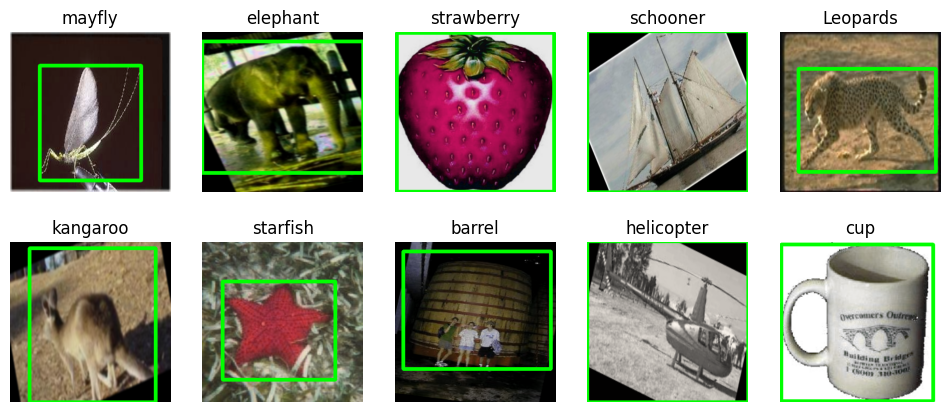

In [12]:
plot(ds_train, 2, 5, idx_to_cls, transform=torchvision.transforms.ToPILImage())

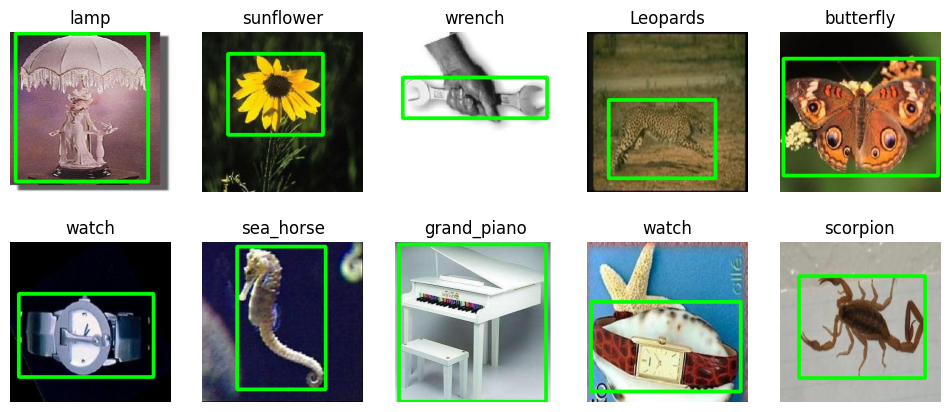

In [13]:
plot(ds_val, 2, 5, idx_to_cls, transform=torchvision.transforms.ToPILImage())

## Model
- NASNET as base model

In [14]:
## Helper
@torch.no_grad()
def loss_acc_loader(model, data_loader, device):
    model.eval()

    total_predicts = []
    total_targets = []
    total_class_loss = 0
    total_bbox_loss = 0
    for data, labels, bbox in data_loader:
        data = data.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)

        class_logits, bbox_logits = model(data)

        total_class_loss += class_criterion(class_logits, labels).item()
        total_bbox_loss += bbox_criterion(bbox_logits, bbox).item()


        total_predicts.append(class_logits.argmax(1))
        total_targets.append(labels)

    total_predicts = torch.concat(total_predicts)
    total_targets = torch.concat(total_targets)

    avg_class_loss = total_class_loss / len(data_loader)
    avg_bbox_loss = total_bbox_loss / len(data_loader)
    accuracy = (total_predicts == total_targets).float().mean().item()

    return avg_class_loss, avg_bbox_loss, accuracy, total_predicts, total_targets


def get_parameters_info(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    nontrainable = sum(p.numel() for p in model.parameters() if p.requires_grad==False)

    return trainable, nontrainable

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


### Defining

In [15]:
num_classes = len(cls_to_idx)
bbox_len = 4

class TwoHeadNetwork(nn.Module):
    def __init__(self, input_shape, num_classes, bbox_len, trainable=False):
        super(TwoHeadNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.bbox_len = bbox_len
        self.mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

        for p in self.mobilenet.parameters(): p.requires_grad=trainable
        # self.mobilenet.avgpool = Identity()
        self.mobilenet.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.mobilenet.classifier = Identity()

        self.bbox_head = nn.Sequential(nn.Linear(960, 1250), nn.ReLU(), nn.Dropout(0.2),
                                        nn.Linear(1250, 256), nn.ReLU(), nn.Dropout(0.2),
                                        nn.Linear(256, 128), nn.ReLU(),
                                        nn.Linear(128, 64), nn.ReLU(),
                                        nn.Linear(64, 32), nn.ReLU(),
                                        nn.Linear(32, self.bbox_len))

        self.class_head = nn.Sequential(nn.Linear(960, 1250), nn.ReLU(), nn.Dropout(0.2),
                                        nn.Linear(1250, 256), nn.ReLU(), nn.Dropout(0.2),
                                        nn.Linear(256, 128), nn.ReLU(),
                                        nn.Linear(128, 64), nn.ReLU(),
                                        nn.Linear(64, 32), nn.ReLU(),
                                        nn.Linear(32, self.num_classes))

    def forward(self, x):
        features = self.mobilenet(x)
        features = features.view(features.size(0), -1)
        class_out = self.class_head(features)
        bbox_out = self.bbox_head(features)

        return class_out, bbox_out

In [16]:
twoHeadMob = TwoHeadNetwork(image_shape, num_classes, bbox_len).to(device)
tr, nontr = get_parameters_info(twoHeadMob)
print(f"Total trainable parameters= {tr}\nTotal non-trainable parameters= {nontr}")

class_criterion = nn.CrossEntropyLoss()  # Classification loss
bbox_criterion = nn.MSELoss()  # bbox loss

optim = torch.optim.Adam(twoHeadMob.parameters(), lr)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=4)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 86.0MB/s]


Total trainable parameters= 3132809
Total non-trainable parameters= 2971952


### Training Loop

In [17]:
## OVERFIT ONE BATCH
# data, labels, bbox = next(iter(train_loader))
# data = data.to(device)
# labels = labels.to(device)
# bbox = bbox.to(device)

# for epoch in range(1, 5001):
#     twoHeadMob.train()  # Set the model to training mode
    
#     class_logits, bbox_logits = twoHeadMob(data)

#     class_loss = class_criterion(class_logits, labels)
#     bbox_loss = bbox_criterion(bbox_logits, bbox)
#     loss = class_loss + bbox_loss

#     optim.zero_grad()
#     loss.backward()
#     optim.step()
#     if epoch % 100 == 0 or epoch==1:
#         print(f'Epoch {epoch}/{1000}: ', end='\n')
#         print(f' Class Loss {class_loss:.4f}, Bbox Loss {bbox_loss:.4f}')


In [18]:
total_batches = len(train_loader)
train_class_losses = []
train_bbox_losses = []
val_class_losses = []
val_bbox_losses = []

for epoch in range(epochs):
    twoHeadMob.train()  # Set the model to training mode

    print(f'Epoch {epoch+1}/{epochs}: ', end='\n')
    for batch_idx, (data, labels, bbox) in enumerate(train_loader):

        data = data.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)

        class_logits, bbox_logits = twoHeadMob(data)

        class_loss = class_criterion(class_logits, labels)
        bbox_loss = bbox_criterion(bbox_logits, bbox)
        loss = class_loss + bbox_loss

        optim.zero_grad()
        loss.backward()
        optim.step()

    # Running model on the entire train and validation dataset after each epoch
    train_class_loss, train_bbox_loss, train_accuracy, _, _ = loss_acc_loader(twoHeadMob, train_loader, device)
    train_class_losses.append(train_class_loss)
    train_bbox_losses.append(train_bbox_loss)
    
    val_class_loss, val_bbox_loss, val_accuracy, _, _ = loss_acc_loader(twoHeadMob, val_loader, device)
    val_class_losses.append(val_class_loss)
    val_bbox_losses.append(val_bbox_loss)
    print(f' Train: Class Loss {train_class_loss:.4f}, Bbox Loss {train_bbox_loss:.4f}, Accuracy {train_accuracy*100:.2f}%')
    print(f'  Validation: Class Loss {val_class_loss:.4f}, Bbox Loss {val_bbox_loss:.4f}, Accuracy {val_accuracy*100:.2f}%')


Epoch 1/50: 
 Train: Class Loss 2.8338, Bbox Loss 0.0131, Accuracy 30.79%
  Validation: Class Loss 2.8020, Bbox Loss 0.0142, Accuracy 33.82%
Epoch 2/50: 
 Train: Class Loss 1.7703, Bbox Loss 0.0119, Accuracy 51.73%
  Validation: Class Loss 1.8355, Bbox Loss 0.0134, Accuracy 51.53%
Epoch 3/50: 
 Train: Class Loss 1.1601, Bbox Loss 0.0097, Accuracy 67.66%
  Validation: Class Loss 1.3235, Bbox Loss 0.0114, Accuracy 65.70%
Epoch 4/50: 
 Train: Class Loss 0.8910, Bbox Loss 0.0091, Accuracy 74.29%
  Validation: Class Loss 1.1767, Bbox Loss 0.0115, Accuracy 67.63%
Epoch 5/50: 
 Train: Class Loss 0.7617, Bbox Loss 0.0077, Accuracy 78.09%
  Validation: Class Loss 1.0485, Bbox Loss 0.0101, Accuracy 72.46%
Epoch 6/50: 
 Train: Class Loss 0.6520, Bbox Loss 0.0074, Accuracy 81.09%
  Validation: Class Loss 0.9708, Bbox Loss 0.0096, Accuracy 75.04%
Epoch 7/50: 
 Train: Class Loss 0.5042, Bbox Loss 0.0077, Accuracy 85.40%
  Validation: Class Loss 0.9422, Bbox Loss 0.0096, Accuracy 78.10%
Epoch 8/50: 


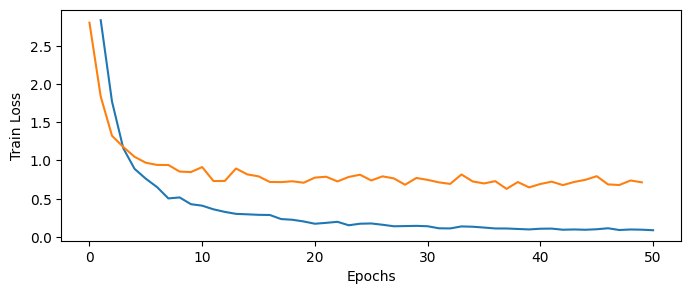

In [19]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_class_losses))], train_class_losses, val_class_losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

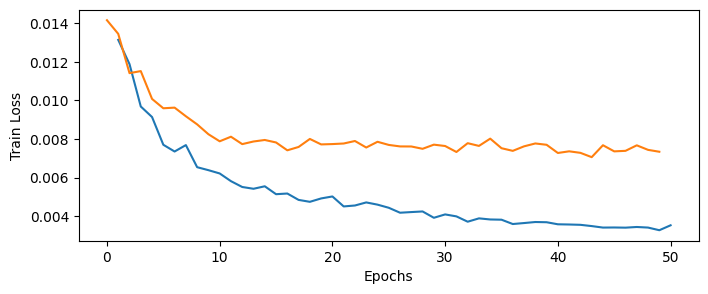

In [20]:
plt.figure(figsize=(8, 3))
plt.plot([ep+1 for ep in range(len(train_bbox_losses))], train_bbox_losses, val_bbox_losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

## Evaluation

In [21]:
test_class_loss, test_bbox_loss, test_accuracy, _, _ = loss_acc_loader(twoHeadMob, test_loader, device)

print(f'Test: Class Loss {test_class_loss:.4f}, Bbox Loss {test_bbox_loss:.4f}, Accuracy {test_accuracy*100:.2f}%')


Test: Class Loss 0.5971, Bbox Loss 0.0067, Accuracy 88.89%


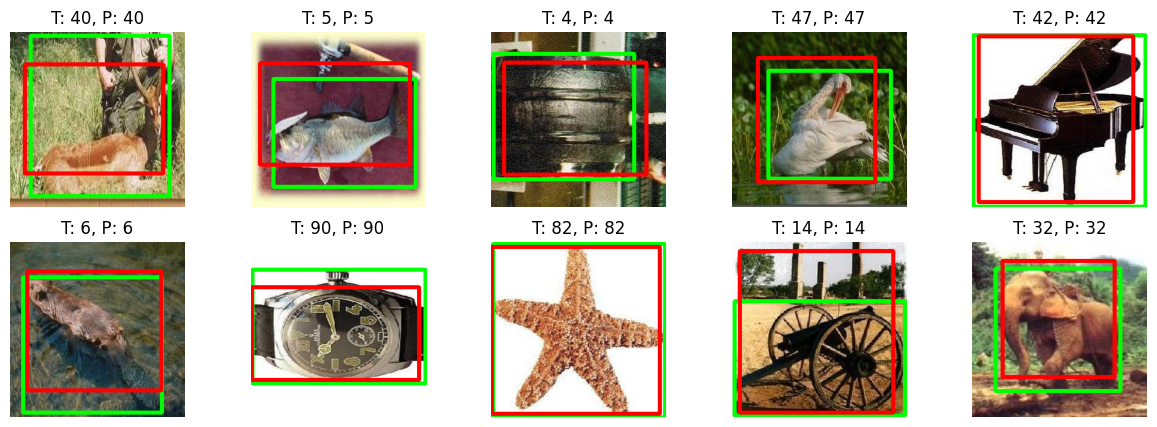

In [22]:
rows=2
cols=5
fig, axs = plt.subplots(rows,cols, figsize=(15,5))
axs = axs.ravel()
pil_tran = torchvision.transforms.ToPILImage()
indices = torch.randint(0, len(ds_test), (rows*cols,))
for ax, idx in zip(axs, indices):
    image, label, bbox = ds_test[idx]
    image = image.to(device)
    
    class_logits, bbox_logits = twoHeadMob(image.unsqueeze(0))
    bbox_logits = bbox_logits.squeeze(0)
    image = pil_tran(image)
    
    image = cv2.rectangle(np.array(image), (int(bbox[0]*300),int(bbox[1]*300)), (int(bbox[2]*300),int(bbox[3]*300)), (0,255,0),5)
    image = cv2.rectangle(np.array(image), (int(bbox_logits[0].item()*300),int(bbox_logits[1].item()*300)), (int(bbox_logits[2].item()*300),int(bbox_logits[3].item()*300)), (255,0,0),5)
    
#     class_name = idx_to_cls[label.item()]
    predicted_label = torch.argmax(class_logits, dim=1).item()
#     predicted_name = idx_to_cls[torch.argmax(class_logits, dim=1).item()]

    ax.imshow(image)
    ax.set_title(f"T: {label}, P: {predicted_label}")
    ax.axis('off')

### Saving

In [23]:
model_states = {'model_state': twoHeadMob.state_dict(),
                'optim_state': optim.state_dict(),
                'batch_size': batch_size,
                'loss_tr': {'train_class_loss': train_class_loss, 'train_bbox_loss': train_bbox_loss},
                'loss_ts': {'test_class_loss': test_class_loss, 'test_bbox_loss': test_bbox_loss}}
torch.save(model_states, '/kaggle/working/twoHeadMob_states.pt')